# Tutorial Notebook for nisarhdf.nisarGCOVHDF
---

This notebook demonstrates the functionality of `nisarGCOVHDF`, which is at tool for reading NISAR **GCOV** products.  Some of its functionality is specifically developed for the Greenland Mapping Project (GrIMP) workflows, but it may also be of general use for working with these products. If nothing else, the source code provides examples of how to unpack these projects.

## Installation

The easiest way to ensure the code works is to create a custom environment using the *environment.yml* file included in this *nisarhdf* repository. To do so execute the following,

`conda env create -f environment.yml`

Then setup the kernel for the Jupyter notebooks with the command:

`python -m ipykernel install --user --name=nisarcryo`

Then activate the environment:

`conda activate nisarcryo`

Finally, start Jupyter and open the notebooks.

**Even if you want to work with your existing environment, the *environment.yml* file demonstrates which packages must be installed if they are not already present.**


## Python Imports

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rioxarray
from osgeo import gdal

In [2]:
def autoScaleRange(myVar, percentile):
        '''
        If percentile less than 100, will select vmin as (100-percentile)
        and vmax as percentile of myVar, unless they fall out of the vmin and
        vmax bounds.
        Parameters
        ----------
        myVar : nparray
            Data being displayed.
        vmin : float
            Absolute minimum value.
        vmax : TYPE
            absolute maximum value.
        percentile : TYPE
            Clip data at (100-percentile) and percentile.

        Returns
        -------
        vmin, vmax - updated values based on percentiles.
        '''
        vmax = np.percentile(myVar[np.isfinite(myVar)], percentile)
        vmin = np.percentile(myVar[np.isfinite(myVar)], 100 - percentile)
        return vmin, vmax

In [3]:
def createDivider(ax, colorBarPosition='right', colorBarSize='5%',
                   colorBarPad=0.05):
    '''
    Create divider for color bar
    '''
    divider = make_axes_locatable(ax)  # Create space for colorbar
    return divider.append_axes(colorBarPosition, size=colorBarSize,
                               pad=colorBarPad)

def colorBar(pos, ax, colorBarLabel, colorBarPosition, colorBarSize,
              colorBarPad, labelFontSize, plotFontSize, extend='max',
              fontScale=1):
    '''
    Color bar for image
    '''
    # Create an divided axis for cb
    cbAx = createDivider(ax, colorBarPosition=colorBarPosition,
                             colorBarSize=colorBarSize,
                               colorBarPad=colorBarPad)
    # Select orientation
    orientation = {'right': 'vertical', 'left': 'vertical',
                   'top': 'horizontal',
                   'bottom': 'horizontal'}[colorBarPosition]

    cb = plt.colorbar(pos, cax=cbAx, orientation=orientation,
                      extend=extend)
    cb.set_label(colorBarLabel, size=labelFontSize * fontScale)
    cb.ax.tick_params(labelsize=plotFontSize * fontScale)
    if colorBarPosition in ['right', 'left']:
        cbAx.yaxis.set_ticks_position(colorBarPosition)
        cbAx.yaxis.set_label_position(colorBarPosition)
    elif colorBarPosition in ['top', 'tottom']:
        cbAx.xaxis.set_ticks_position(colorBarPosition)
        cbAx.xaxis.set_label_position(colorBarPosition)

## Open the HDF

Edit the path below to point to the ROFF product you wish to work with.

In [4]:
GCOVFile = '/Volumes/insar1/ian/NISAR/GCOV/gcov.h5'

Create an instance and open the hdf as shown below. For normal products, you shouldn't have to specify the orbit, but while the orbit fields are present in the example file, they are not populated. When you open the hdf, you can specify the precise orbit XMLs if desired, which are release a few weeks after the MOI orbits used in the processing.

In [5]:
myGCOV = nisarhdf.nisarGCOVHDF()
myGCOV.openHDF(GCOVFile, referenceOrbitXML=None, referenceOrbit=0, frame=0)

sar LSAR
product GCOV
frequency frequencyA
productType None
polarization None
layer None
productData None
bands grids
isSecondary False
referenceOrbitXML None
secondaryOrbitXML None
None
GCOV zeroDopplerStartTime
use numpy True
use numpy True
use numpy True
use numpy True


## GCOV Parameters

A summary of some of the more important parameters for the **GCOV** products can be obtained by.

In [6]:
myGCOV.printParams()

GCOV.referenceOrbit = 0 
GCOV.datetime = 2024-04-03 08:47:47 
GCOV.referenceGranule = input_L1-antarctica/NISAR_L1_PR_RSLC_069_099_D_120_0500_SVNA_S_20240403T084747_20240403T084821_A00404_F_F_J_001.h5 
GCOV.frame = 0 
GCOV.LookDirection = left 
GCOV.PassType = descending 
GCOV.Wavelength = 0.24542976504297995 
GCOV.PRF = 1520.0 
GCOV.epsg = 3031 
GCOV.NumberRangeLooks = 1 
GCOV.NumberAzimuthLooks = 1 

Data Fields
GCOV.VVVV
GCOV.mask
GCOV.numberOfLooks
GCOV.rtcGammaToSigmaFactor


## Display Data

The following plots the fields associated with the **GCOV** product.

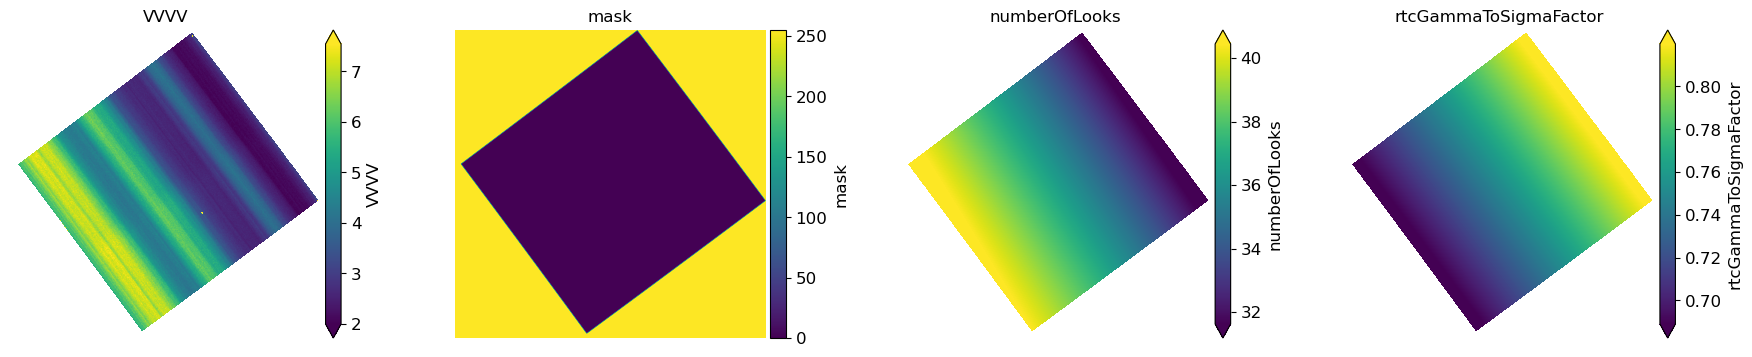

In [7]:
fields = myGCOV.dataFields
fig, axes = plt.subplots(1, len(fields), figsize=(22, 4))
for field, ax in zip(fields, axes.flatten()):
    data = getattr(myGCOV, field)
    vmin, vmax = autoScaleRange(data, 95)
    if field not in ['mask']:
        h = ax.imshow(data, vmin=vmin, vmax=vmax, origin='upper')
        colorBar(h, ax, field, 'right', '5%',.05, 12, 12, extend='both')
    else:
        h = ax.imshow(data)
        colorBar(h, ax, field,'right', '5%',.05, 12, 12, extend='neither')
    ax.set_title(field)
    ax.axis('off')

## Metadata Interpolation

Much of the spatially dependent information (e.g., incidenceAngle) is stored as metadata cubes (see nisar documenation). These cubes can be interpolatated to obtain the x, y, and elevation dependent results. Here are examples of how to extract these data for the offset grids.

For each field, there is an interpolator method (e.g., `myGCOV.incidenceAngleCube(x, y, z)`). The examples below demonstrate how to interpolate the data cubes to the coordinates of the GCOV product.

### Setup Grid for the Offsets

In this step a range/Dopper grid corresponding to the offset maps is created. Note in this example we assume zero elevation, but the values can easily be substituted from a DEM.

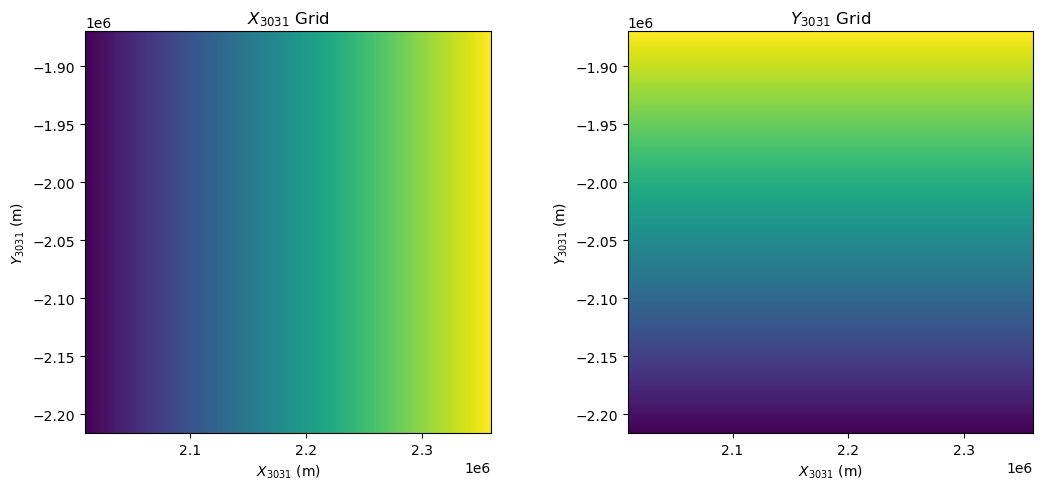

In [8]:
myGCOV.setupXYGrid()
z = np.zeros(myGCOV.xGrid.shape)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes[0].imshow(myGCOV.xGrid, extent=myGCOV.extentUL)
axes[1].imshow(myGCOV.yGrid, extent=myGCOV.extentUL)
for ax, field in zip(axes, [f'$X_{{{myGCOV.epsg}}}$ Grid',f'$Y_{{{myGCOV.epsg}}}$ Grid']):
    ax.set_title(field)
    ax.locator_params(axis='x', nbins=4)
    ax.set_title(field)
    ax.set_xlabel(f'$X_{{{myGCOV.epsg}}}$ (m)')
    ax.set_ylabel(f'$Y_{{{myGCOV.epsg}}}$ (m)')
fig.tight_layout()

### Incidence and Elevation Angles

The incidence and elevation angles can be computed as follows:

incidenceAngle min/max: 34.184 47.047
elevationAngle min/max: 30.074 40.757


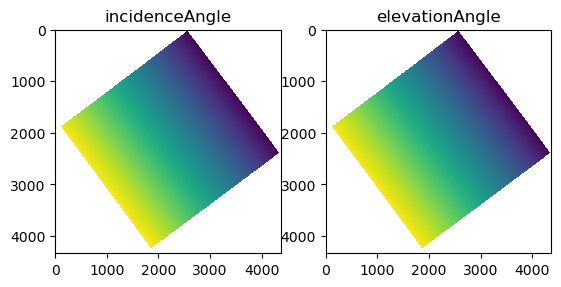

In [9]:
incidenceAngle = myGCOV.incidenceAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
elevationAngle = myGCOV.elevationAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [incidenceAngle, elevationAngle], ['incidenceAngle', 'elevationAngle']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Ground Track Velocity

The ground track velocity is found by:

groundTrackVelocity min/max: 6684.104 6708.946


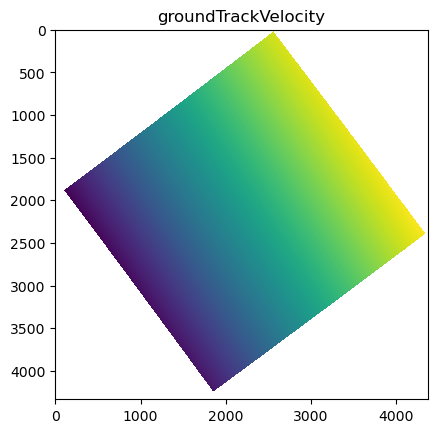

In [10]:
groundTrackVelocity=  myGCOV.groundTrackVelocityCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
fig, ax = plt.subplots(1,1)
ax.imshow(groundTrackVelocity, origin='upper')
ax.set_title('groundTrackVelocity')
print(f'groundTrackVelocity min/max: {np.nanmin(groundTrackVelocity):.3f} {np.nanmax(groundTrackVelocity):.3f}')

### Range-Doppler Coordinate

The `slantRange` and `zeroDopplerTime` coordinate at corresponding to the `x` and `y` can can be determined as:

In [11]:
slantRange, zeroDopplerTime =  myGCOV.rangeDopplerCube(myGCOV.xGrid, myGCOV.yGrid, z, image='reference', maskNoData=myGCOV.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [slantRange, zeroDopplerTime], ['slantRange', 'zeroDopplerTime']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

KeyError: "Unable to synchronously open object (object 'referenceSlantRange' doesn't exist)"

## Baseline Components

The perpendicular and parallel baseline components are computed as follows:

In [ ]:
bn, bp =  myGCOV.baselineCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
fig, axes = plt.subplots(1, 2)
for ax, var, title in zip(axes.flatten(), [bn, bp], ['bn', 'bp']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)
    print(f'{title} min/max: {np.nanmin(var):.3f} {np.nanmax(var):.3f}')

### Along Track Unit Vector and LOS Unit Vector

The x and y components of the line-of-sight and along-track unit vector can be determined on the offset grid by:

In [ ]:
ATx, ATy =  myGCOV.alongTrackUnitVectorCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
LOSx, LOSy=  myGCOV.losUnitVectorCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations)
#
fig, axes = plt.subplots(1, 4, figsize=(15,5))
for ax, var, title in zip(axes.flatten(), [ATx, ATy, LOSx, LOSy], ['Along Track Vel. X', 'Along Track Vel. Y', 'LOS X', 'LOS Y']):
    ax.imshow(var, origin='upper')
    ax.set_title(title)

## Other Meta Data

Most of the essential meta data has been parsed and demonstrated in the examples above. Other quantities can be extracted by keyword from the h5 files. For example, the **centerFrequency** can be extracted as:

In [ ]:
np.array(myGCOV.h5['GCOV']['grids']['frequencyA']['centerFrequency']).item()

## Save Data to Binary or Tiff Files.

The data from the hdf can be save as individual tiffs, bound together by a single vrt file. The default is to write all of the bands e.,g `'VVVV'`, `'mask'`, `'numberOfLooks'`, and `'rtcGammaToSigmaFactor'` for a **GCOV** product, which is accomplished as follows.

In the previous example, the results were save as tiffs. To save as binary files, run with `tiff=False` for a more limited set of bands:

In [ ]:
myGCOV.writeData('output/GCOVbinary', bands=['VVVV', 'rtcGammaToSigmaFactor'], tiff=False)
!ls output/GCOVbinary*

The data can be read back in as an `rioxarray`  using `nisarhdf.readVrtAsXarray`, which saves each band as a named data variable. The results can be displayed using the `xarray` version of `imshow`.

In [ ]:
GCOVbinary = nisarhdf.readVrtAsXarray('output/GCOVbinary.vrt', mask_and_scale=True)
#extent = [np.min(GCOVbinary.x), np.max(GCOVbinary.x), np.min(GCOVbinary.y), np.max(GCOVbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GCOVbinary.VVVV.plot.imshow(ax=axes[0], cmap='gray')
GCOVbinary.rtcGammaToSigmaFactor.plot.imshow(ax=axes[1], cmap='RdBu_r')
GCOVbinary

## Save Gridded Data Cubes

The gridded data cubes can also be saved as either flat binary or as cloud-optimized geotiff (COG) files. In this case, use `save=True` to save the result internally, and then use `writeData` to save data the same way the other bands are saved. In the example below, the data are saved as COGs.

In [ ]:
myGCOV.incidenceAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations, save=True);
myGCOV.elevationAngleCube(myGCOV.xGrid, myGCOV.yGrid, z, maskNoData=myGCOV.noDataLocations, save=True);
myGCOV.writeData('output/GCOVangles',bands=['incidenceAngle', 'elevationAngle'], tiff=True) # ', 'elevationAngle'

In [ ]:
GCOVTiff = nisarhdf.readVrtAsXarray('output/GCOVangles.vrt', mask_and_scale=True)
#extent = [np.min(GCOVbinary.x), np.max(GCOVbinary.x), np.min(GCOVbinary.y), np.max(GCOVbinary.y)
# Get the band names
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
GCOVTiff.incidenceAngle.plot.imshow(ax=axes[0])
GCOVTiff.elevationAngle.plot.imshow(ax=axes[1], cmap='RdBu_r')
GCOVTiff

# Anything below here is debug code that can be ignored

In [ ]:
azSpVG = myGCOV.groundTrackVelocityCube(myGCOV.xGrid, myGCOV.yGrid, z) *  myGCOV.SLCZeroDopplerTimeSpacing
azSpC = myGCOV.SLCAzimuthPixelSize

In [ ]:
azSpC

In [ ]:
print(np.nanmin(azSpVG)/azSpC, np.nanmax(azSpVG)/azSpC)